# Musical Note Classification

## Pre-processing

In [1]:
# Import libraries
import os, fnmatch
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [10]:
# Importing datasets from files to array
labels = []
files = []
#notes = ['A3','A4','A5','A6','As3','As4','As5','As6','B3','B4','B5','B6','B7','C4','C5','C6',
#        'C7','Cs4','Cs5','Cs6','Cs7','D4','D5','D6','D7','Ds4','Ds5','Ds6','Ds7','E4','E5'
#        'E6','E7','F4','F5','F6','F7','Fs4','Fs5','Fs6','Fs7','G3','G4','G5','G6','G7','Gs3',
#        'Gs4','Gs5','Gs6','Gs7']

notes = ['_As', '_A', '_B', '_Cs', '_C', '_Ds', '_D', '_E', '_Fs', '_F', '_Gs', '_G']

# Load violin data and append a new violin label & file path 
# for each '.wav' file found 

#path='Datasets/philharmonia/violin/'
path='Datasets/combinedNotes/'
for file in os.listdir(path):
    if fnmatch.fnmatch(file, '*.wav'):
        files.append(path+file)
        #print(file)
for file in files:
    for note in notes:
        if fnmatch.fnmatchcase(file, '*'+note+'*'):
            labels.append(note)
            break
    else:
        labels.append('other')        
#files
#labels

In [11]:
# Encode target values found in 'labels' array
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
Y = le.transform(labels)
Y

array([ 7,  7, 10,  8, 11,  1,  4,  6,  3, 11,  0,  2, 10, 11,  1,  3,  2,
       11,  7,  1,  9,  6, 10, 11,  2,  9,  4,  4,  3,  7,  2, 10, 11,  1,
       10,  6,  3,  5,  0,  3,  6, 11,  9, 11,  0,  3,  9,  6,  6,  2,  8,
        5,  6,  1,  0,  9, 11,  5,  6,  0,  4,  4, 10,  7,  2,  0, 10,  1,
        3,  0,  5,  3, 10,  4,  5,  2,  6,  4,  9,  9, 10,  5, 10,  5,  8,
       11,  0,  1,  3,  8, 10,  1,  9,  6,  5,  2,  1, 10,  4,  5, 10, 10,
        3,  8,  2,  3,  4,  9,  8, 11,  8, 10,  2,  8, 11,  9,  1,  0,  5,
        5,  0,  5,  8,  8,  0,  9,  7,  0,  4,  7,  2,  7,  3,  6,  1, 11,
        0,  6,  3,  8,  8, 11,  9,  1,  7,  0, 11,  9,  2,  0,  1,  4,  1,
        6,  7,  4,  6,  8,  7,  7,  3,  1,  9,  7,  9,  5,  3,  2,  7, 10,
        4,  4,  9,  5,  4,  2,  7,  4, 11,  8,  1,  6,  7,  6,  0,  8,  3,
        5,  8,  5])

In [23]:
# Load files from 'files' array & extract MFCC data
X = []
for file in (files):
    data, sr = librosa.load(file)
    if len(data) is None:  # Catch error for incorrect file loading
        print("Error loading")
        break
    stft_data = librosa.stft(data, n_fft=2048, hop_length=512)   
    spec_data = np.abs(stft_data) ** 2
    features = np.mean(spec_data,1)
    X.append(features)  # Append MFCC audio features to X data array

In [24]:
# Split the X and Y data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [25]:
# Data scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() 
scaled_X_train  = sc.fit_transform(X_train)
scaled_X_test = sc.fit_transform(X_test)

## Neural Network model

In [26]:
# Apply the Neural Netwrok learning model and train it
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=10000, alpha=0.05, hidden_layer_sizes=(200,), solver='lbfgs')
model.fit(scaled_X_train, Y_train)

# Get model predictions
pred_Y_train = model.predict(scaled_X_train)
pred_Y_test = model.predict(scaled_X_test)

# Evaluate the model
scaledTrainScore="Scaled train score = {:0.3f}".format(model.score(scaled_X_train, Y_train))
scaledTestScore="Scaled test score = {:0.3f}".format(model.score(scaled_X_test, Y_test))

In [27]:
# Basic model accuracy
print(scaledTrainScore)
print(scaledTestScore)

Scaled train score = 1.000
Scaled test score = 0.921


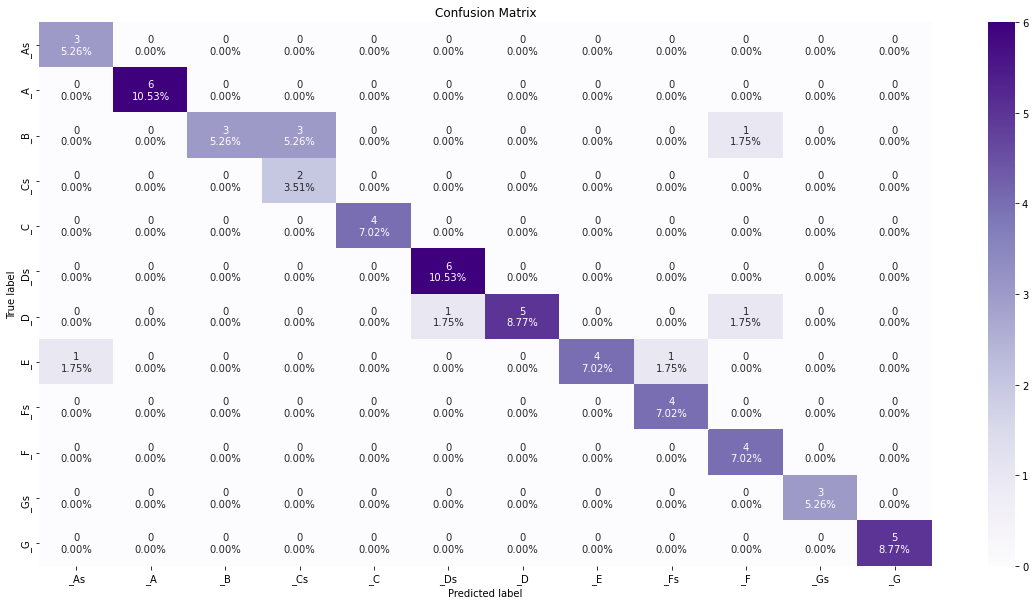

In [18]:
# Plot Confusion Matrix
from cf_matrix import make_confusion_matrix  # Import library
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(Y_test, pred_Y_test)  # Creating a simple confusion matrix
labels = ['True Negative','False Positive','False Negative','True Positive']  # set data labels
categories = notes # set target categories
make_confusion_matrix(cfm,  # function to format confusion matrix
                      title='Confusion Matrix',
                      group_names=labels,
                      categories=categories,
                      sum_stats=False,
                      percent=True,
                      cmap='Purples',
                      figsize=(20,10))


In [11]:
# Use of Cross validation with a new model

X_scaled = sc.fit_transform(X)  # scale all the X data
from  sklearn.model_selection import cross_val_score  # Import cross validation methods

# Create the second Logistic regression model
crossValModel = MLPClassifier(max_iter=5000, alpha=0.05, hidden_layer_sizes=(200,), solver='lbfgs')  

# Use cross_val_score to calculate the accuracy of the model using cross validation
crossValScore = cross_val_score(crossValModel, X_scaled, Y, cv = 10, scoring='accuracy')
print("Cross Validation Model accuracy: ",crossValScore.mean()) # print mean average of the 10 partitianed scores

Cross Validation Model accuracy:  0.8834437086092717


In [12]:
newgridSearchModel = MLPClassifier()   # create a new logistic regression model for grid search

# create dictionary of parameters for Neural Network
param_grid = [
    {'hidden_layer_sizes': [(200,),(100,),(50,)],
     'activation': ['identity', 'logistic', 'tanh', 'relu'],
     'solver': ['lbfgs', 'sgd', 'adam'],
     'alpha': [0.001, 0.05],
     'learning_rate': ['constant', 'invscaling', 'adaptive'],}
]

# Grid Seach with 10 fold CV
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(gridSearchModel, param_grid, cv=5, verbose=True, n_jobs=-1, scoring='accuracy')
grid.fit(X_scaled, Y)  # fit the instsantiated grid with scaled data

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# Accuracy of the grid search hyper-parameter tuned model
print (grid.best_params_)
print (grid.best_estimator_)
print ("Best Tuned Accuracy: {:.6f}".format(grid.best_score_))

## Logistic Regression model

In [30]:
# Apply the Logistical regression learning model and train it
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(scaled_X_train, Y_train)  # Train the model using the training data

# Get model predictions
pred_Y_train = model.predict(scaled_X_train)
pred_Y_test = model.predict(scaled_X_test)

# Evaluate the model
scaledTrainScore="Scaled train score = {:0.3f}".format(model.score(scaled_X_train, Y_train))
scaledTestScore="Scaled test score = {:0.3f}".format(model.score(scaled_X_test, Y_test))

In [31]:
# Basic model accuracy
print(scaledTrainScore)
print(scaledTestScore)

Scaled train score = 1.000
Scaled test score = 0.947


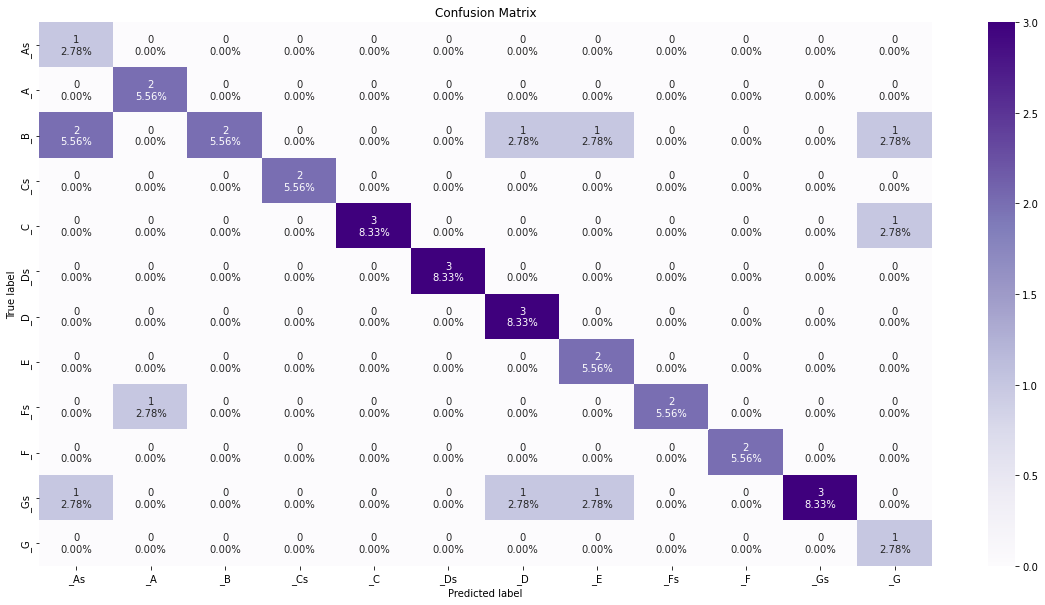

In [18]:
# Plot Confusion Matrix
from cf_matrix import make_confusion_matrix  # Import library
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(Y_test, pred_Y_test)  # Creating a simple confusion matrix
labels = ['True Negative','False Positive','False Negative','True Positive']  # set data labels
categories = notes # set target categories
make_confusion_matrix(cfm,  # function to format confusion matrix
                      title='Confusion Matrix',
                      group_names=labels,
                      categories=categories,
                      sum_stats=False,
                      percent=True,
                      cmap='Purples',
                      figsize=(20,10))


In [ ]:
# Use of Cross validation with a new model

X_scaled = sc.fit_transform(X)  # scale all the X data
from  sklearn.model_selection import cross_val_score  # Import cross validation methods

# Create the second Logistic regression model
crossValModel = LogisticRegression()  

# Use cross_val_score to calculate the accuracy of the model using cross validation
crossValScore = cross_val_score(crossValModel, X_scaled, Y, cv = 10, scoring='accuracy')
print("Cross Validation Model accuracy: ",crossValScore.mean()) # print mean average of the 10 partitianed scores

## Support Vector Machine

In [28]:
from sklearn.svm import SVC
model = SVC()
model.fit(scaled_X_train, Y_train)  # Train the model using the training data

# Get model predictions
pred_Y_train = model.predict(scaled_X_train)
pred_Y_test = model.predict(scaled_X_test)

# Evaluate the model
scaledTrainScore="Scaled train score = {:0.3f}".format(model.score(scaled_X_train, Y_train))
scaledTestScore="Scaled test score = {:0.3f}".format(model.score(scaled_X_test, Y_test))

In [29]:
# Basic model accuracy
print(scaledTrainScore)
print(scaledTestScore)

Scaled train score = 0.822
Scaled test score = 0.421
